# Anomaly Detection on Machine Failures

   <em><b> --- By I Made Krisna Jaya --- </em></b>

In this case, we will build an anomaly detection model for vibration failure dataset using Long Short-Term Memory (LSTM) autoencoder model.

# Introduction
Condition Based Maintenance (CBM) uses sensor to to collect real-time measurement (ie. pressure, temperature, and vibration). CBM data allows maintenance personnel to perform maintenance at the exact moment it is needed, prior to failure.

![](https://files.fm/f/9g8xpvsp5)

Benefit of CBM :
*  Improved equipment lifespan
*  Reduced cost of equipment maintenance
*  Improved prioritization and utilization of maintenance time
*  Fewer unplanned downtime events, higher equipment uptime

Up until recently when people spoke about Predictive Maintenance (PdM) this was essentially as a synonym for Condition Based Maintenance. But with the advent of Artificial Intelligence, much lower costs of equipment sensors (IIoT) and machine learning there is clearly a difference appearing between Predictive Maintenance (PDM) and Condition Based Maintenance (CBM). Predictive Maintenance as an extension, a more advanced approach to CBM where we use potentially many process parameters gained from online sensors to determine if our equipment is moving away from stable operating conditions and is heading towards failure.


# What is Anomaly Detection?
Anomaly detection is the process of finding outliers in a given dataset. Outliers are the data objects that stand out amongst other objects in the dataset and do not conform to the normal behavior in a dataset. Anomaly detection is a data science application that combines multiple data science tasks like classification, regression, and clustering (Kotu & Deshpande, 2019).

The assumption is that normal behavior is the quantity of "normal" data available, whereas anomalies are exceptions to the normal state up to the point where normal modeling is performed.

# Long Short-Term Memory Neural Network
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. (Browniee, 2017)

This is a behavior required in complex problem domains like machine translation, speech recognition, and more.

LSTMs are a complex area of deep learning. It can be hard to get your hands around what LSTMs are, and how terms like bidirectional and sequence-to-sequence relate to the field.

#Load Data and Data Wrangling

In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
from tensorflow.random import set_seed 
from keras.layers import Input, Dropout,Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [ ]:
#Import data from google drive
data = pd.read_csv('/content/drive/MyDrive/SML - Data Science Test/BearingVibration_Dataset.csv')

#Cek Data Info
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  982 non-null    object 
 1   Bearing 1   982 non-null    float64
 2   Bearing 2   982 non-null    float64
 3   Bearing 3   982 non-null    float64
 4   Bearing 4   982 non-null    float64
dtypes: float64(4), object(1)
memory usage: 38.5+ KB


In [ ]:
#Convert Unnamed column to datetime format
data['Unnamed: 0'] = pd.to_datetime(data['Unnamed: 0'], format = '%Y-%m-%d %H:%M:%S')

#Rename Unnamed column 
data = data.rename(columns = {'Unnamed: 0':'Date'})

#Set Date column to index
data = data.set_index('Date')

In [ ]:
data

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
Date,,,,
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659
...,...,...,...,...
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817


## Understanding the Data

Measurement files amount total 982 rows

*  **Start of directory data** : 2004-02-12 10:52:39 (Feb 12th, 2004)
*  **End of directory data** : 2004-02-19 06:22:39 (Feb 19th, 2004)

Each data contains 10 minutes of accelerometer data.


## Visualization Data

[Text(0, 0.5, 'Vibration/Acceleration(g)'), Text(0.5, 0, 'Year-Month-Date')]

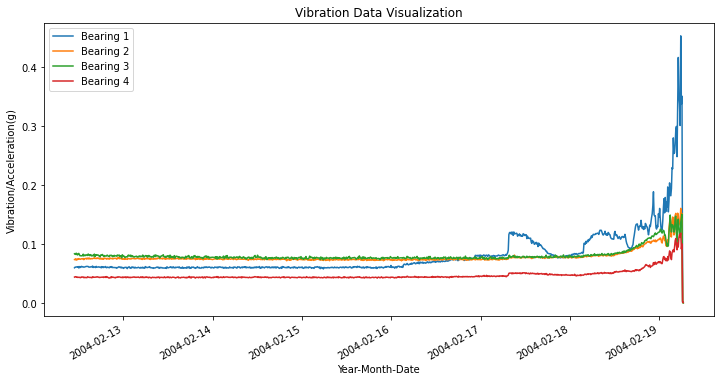

In [ ]:
# Visualising Data
ax = data.plot(figsize = (12,6), title="Vibration Data Visualization" , legend = True)
ax.set(xlabel="Year-Month-Date", ylabel="Vibration/Acceleration(g)")

## Define training and testing data

We define the train and test datasets based on operating conditions, from the vizualization we can see data which represent normal operating condition are until around February 15th, 2004.

In [ ]:
train_data = data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test_data = data['2004-02-15 12:52:39':]
print("Training dataset shape:", train_data.shape)
print("Test dataset shape:", test_data.shape)

Training dataset shape: (445, 4)
Test dataset shape: (538, 4)


#Exploratory Data Analysis

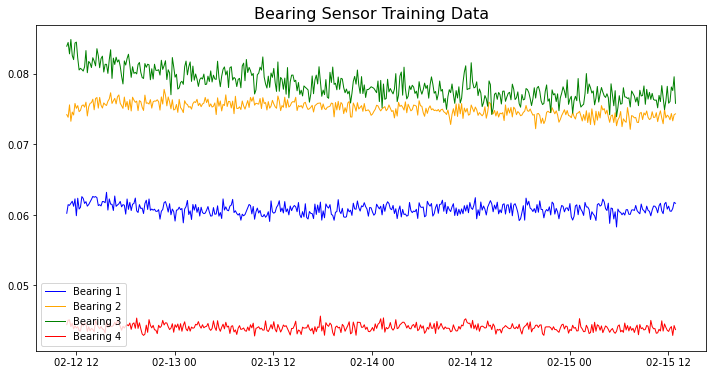

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_data['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_data['Bearing 2'], label='Bearing 2', color='orange', animated = True, linewidth=1)
ax.plot(train_data['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_data['Bearing 4'], label='Bearing 4', color='red', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

Next, we can see the test dataset sensor readings over time

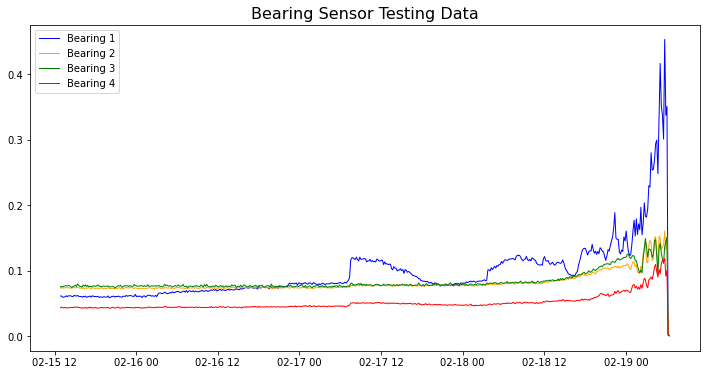

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_data['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_data['Bearing 2'], label='Bearing 2', color='orange', animated = True, linewidth=1)
ax.plot(test_data['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_data['Bearing 4'], label='Bearing 4', color='red', animated = True, linewidth=1)
plt.legend(loc='upper left')
ax.set_title('Bearing Sensor Testing Data', fontsize=16)
plt.show()

We can see that near the failure point, the bearing vibration become oscillate. 

To view the vibrations in a frequency perspective, the data is transformed using the Fourier transform.

In [ ]:
#transforming data to the frequency domain
train_fft = np.fft.fft(train_data)
test_fft = np.fft.fft(test_data)

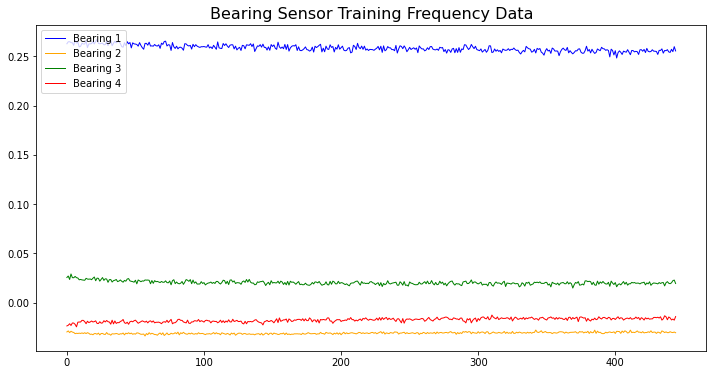

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='orange', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='red', animated = True, linewidth=1)
plt.legend(loc='upper left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

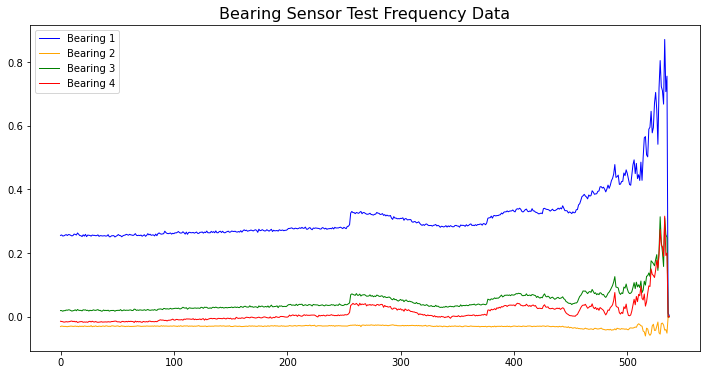

In [ ]:
# Bearing Sensor Test Frequency Data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='orange', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='red', animated = True, linewidth=1)
plt.legend(loc='upper left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

# Modelling

To complete the pre-processing of data, we will normalize data to a range between 0 and 1 using MinMaxScaler.

In [ ]:
#Normalize data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_data)
X_test = scaler.transform(test_data)

reshape input for LSTM models (samples, timesteps, features)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (445, 1, 4)
Test data shape: (538, 1, 4)


For our model we will use an autoencoder neural network architecture. This architecture was chosen to handle model weaknesses due to the selection of training data from normal conditions.

In [ ]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, return_sequences=True)(L3)
    L5 = LSTM(16, return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 16)             1344      
                                                                 
 lstm_5 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector_1 (RepeatVect  (None, 1, 4)             0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_7 (LSTM)               (None, 1, 16)             1344      
                                                           

In [ ]:
# fit model
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
43/43 [==============================] - 9s 44ms/step - loss: 0.4400 - val_loss: 0.3046
Epoch 2/100
43/43 [==============================] - 0s 6ms/step - loss: 0.3462 - val_loss: 0.2043
Epoch 3/100
43/43 [==============================] - 0s 7ms/step - loss: 0.2019 - val_loss: 0.1705
Epoch 4/100
43/43 [==============================] - 0s 7ms/step - loss: 0.1328 - val_loss: 0.1373
Epoch 5/100
43/43 [==============================] - 0s 8ms/step - loss: 0.1222 - val_loss: 0.1299
Epoch 6/100
43/43 [==============================] - 0s 8ms/step - loss: 0.1174 - val_loss: 0.1221
Epoch 7/100
43/43 [==============================] - 0s 7ms/step - loss: 0.1122 - val_loss: 0.1163
Epoch 8/100
43/43 [==============================] - 0s 7ms/step - loss: 0.1072 - val_loss: 0.1171
Epoch 9/100
43/43 [==============================] - 0s 8ms/step - loss: 0.1028 - val_loss: 0.1124
Epoch 10/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0991 - val_loss: 0.1077
Epoch 11

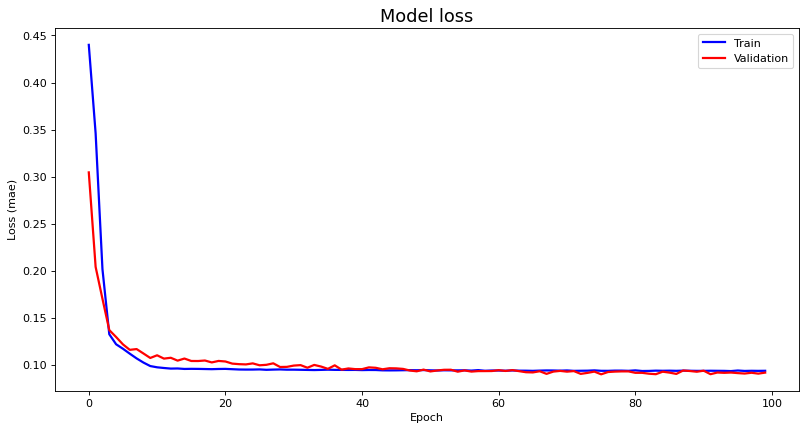

In [ ]:
# plot the training losses
fig, ax = plt.subplots(figsize=(12, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

By plotting the distribution of the calculated loss in the training set, we can determine a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the noise level so that false positives are not triggered.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



(0.0, 0.5)

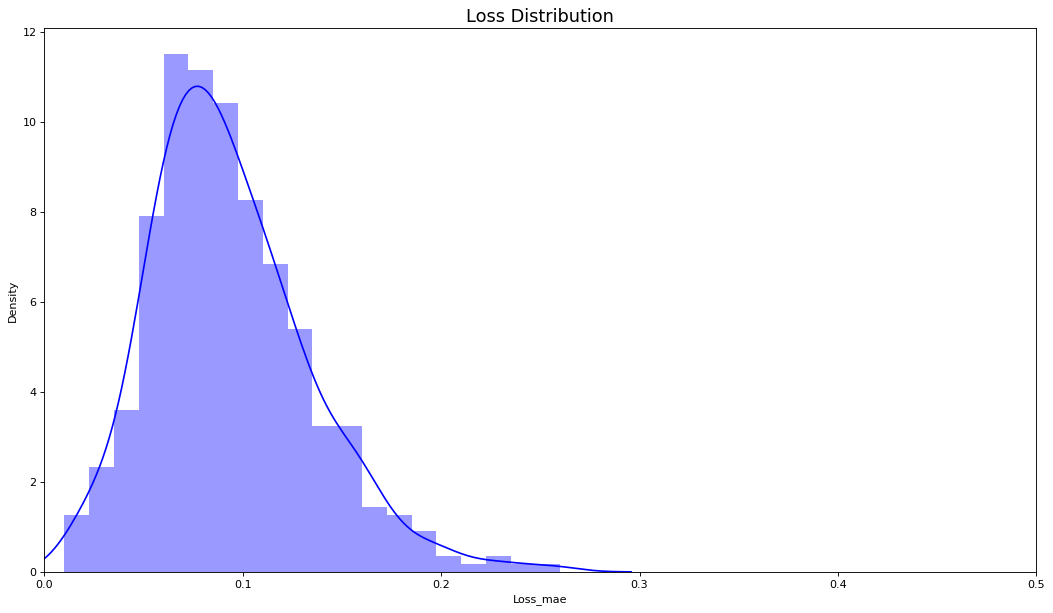

In [ ]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train_data.columns)
X_pred.index = train_data.index

scored = pd.DataFrame(index=train_data.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

From the histogram, we get treshold value of 0.2625

In [ ]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test_data.columns)
X_pred.index = test_data.index

scored = pd.DataFrame(index=test_data.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.2625
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
Date,,,
2004-02-15 12:52:39,0.086773,0.2625,False
2004-02-15 13:02:39,0.174935,0.2625,False
2004-02-15 13:12:39,0.061667,0.2625,False
2004-02-15 13:22:39,0.059596,0.2625,False
2004-02-15 13:32:39,0.042883,0.2625,False


In [ ]:
#Create loss for the training set and concate all data
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train_data.columns)
X_pred_train.index = train_data.index

scored_train = pd.DataFrame(index=train_data.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.2625
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

In [ ]:
scored

,Loss_mae,Threshold,Anomaly
Date,,,
2004-02-12 10:52:39,0.226699,0.2625,False
2004-02-12 11:02:39,0.260152,0.2625,False
2004-02-12 11:12:39,0.139234,0.2625,False
2004-02-12 11:22:39,0.246449,0.2625,False
2004-02-12 11:32:39,0.179093,0.2625,False
...,...,...,...
2004-02-19 05:42:39,31.431241,0.2625,True
2004-02-19 05:52:39,22.011251,0.2625,True
2004-02-19 06:02:39,24.481791,0.2625,True


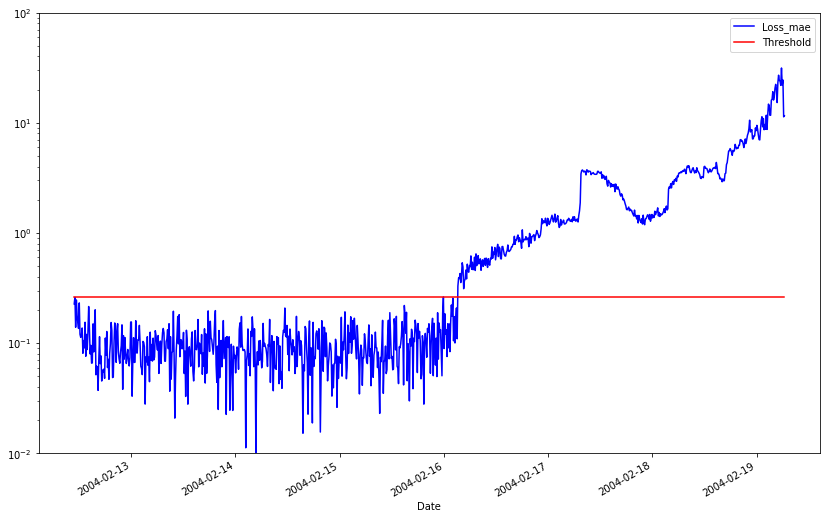

In [ ]:
# failure time plot
scored.plot(logy=True,  figsize=(14,9), ylim=[1e-2,1e2], color=['blue','red'])

In [ ]:
# save model
model.save("anomaly_detection_model.h5")

Model saved


# Conclusion
By analyzing past trends of healthy, the model learns the expected trend with acceptable variance (hyperparameter). From the above vizualization, we see that the model is able to detect the anomaly approximately 3 days ahead of the actual bearing failure.

#References
https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts/
https://www.sciencedirect.com/science/article/pii/B9780128147610000137